# The (Data) Science of Kpop:   Understanding BTS through Data and A.I.

#### Many media outlets have raised and answered their own question of what makes BTS so unique compared to other K-pop groups. Their answers, whether from Vox or Time magazine, aren't really well-supported by evidence, such as the claim that BTS is unique because of "confucian values" or "group synchrony". Fortunately, we have data science, where we can use both traditional and cutting-edge techniques to scientifically explore BTS' true uniqueness, if such a thing exists. This notebook examines two major aspect of BTS: their songs and their lyrics. As many fans have claimed that BTS' lyrics are different compared to their competitors (as well as their music), I will examine and answer these two major claims in this notebook.

<h2>$$Contents$$</h2>

* [1. Data Strategy and EDA](#$$1.\-Data\-Strategy\-and\-EDA$$)
    * [1.1 EDA](#1.1-EDA)
* [2. Modeling (Internal Data)](#$$2.\-Modeling$$)
    * [2.1 Baseline Modeling for a BTS Classifier](#2.1-Baseline-Modeling-for-a-BTS-Classifier)
    * [2.2 Feature Importance](#2.2-Feature-Importance)
    * [2.3 Feature Impact](#2.3-Feature-Impact)
* [3. Lyrics and Natural Language Processing](#$$3.\-Lyrics\-and\-Natural\-Language\-Processing$$)
    * [3.1. Tfidf and LIME ](#3.2-Tfidf-and-LIME)
    * [3.2. Doc2Vec with Gensim](#3.1-Doc2Vec-with-Gensim)
    * [3.3. Creating a BTS Classifier (Lyrics)](#3.2-Creating-a-BTS-Classifier)
    * [3.4. Unsupervised Learning with Latent Dirichlet Allocation](#3.2-Unsupervised-Learning-with-Latent-Dirichlet-Allocation)


# $$1.\ Data\ Strategy\ and\ EDA$$

**Data Strategy:** The data strategy for this notebook is as follows:

1) Obtain the musical features of recently popular k-pop groups using Spotify's API. Parse json files in order to store these features in a workable dataframe.

2) Use BeautifulSoup to webscrape translated English lyrics of k-pop songs from these groups. The lyrics will be used for Natural Language Processing and building k-pop classifier using texts.

3) Code for tapping into Spotify API and scraping the web will be stored in a separate python file.

**4) Important: I will take a one-vs.-all approach. As, our target label will be 1 if BTS and 0 if any other group. This will allow for binary classification when building a classifier.**


__Load Modules and CSV__

In [41]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns


plt.style.use('ggplot')

from seaborn import distplot
import seaborn as sns
from pandas.tools.plotting import scatter_matrix


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

from NLP_helper_functions import *
import spacy
import re

from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import binarize
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
import shap
from itertools import combinations

from sklearn.linear_model import *



# Plotting tools
import pyLDAvis

import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')


%pylab inline

pd.set_option('display.max_colwidth', -1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [42]:
kpop_df = pd.read_csv('data/musical_data/merged_kpop_song_features.csv', index_col = 0)
kpop_df_copy = kpop_df.copy()

In [43]:
kpop_df['release_date'] = pd.to_datetime(kpop_df['release_date'])
kpop_df['year'] = [i.year for i in kpop_df.release_date]
kpop_df['artist_name'] = [i.lower().replace("'", '') for i in kpop_df.artist_name]

>Extracting the year allows us to analyze evolving musical trends by year

## 1.1 EDA

#### High-level data analysis: correlation, seasonality, and distributions.

In [44]:
kpop_df.head(6)

,danceability,energy,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,release_date,song_name,song_name_formatted,year
0,0.637,0.799,2,0.0338,0.3940,0.0,0.0921,0.562,104.995,228615,4,bts,2018-08-24,Euphoria,euphoria,2018
1,0.723,0.906,1,0.2790,0.0907,0.0,0.0771,0.398,125.019,225221,4,bts,2018-08-24,Trivia 起 : Just Dance,trivia-just-dance,2018
2,0.347,0.578,8,0.0626,0.4450,0.0,0.2310,0.226,86.730,276708,5,bts,2018-08-24,Serendipity (Full Length Edition),serendipity-length,2018
3,0.599,0.774,1,0.0541,0.0223,0.0,0.0669,0.696,129.819,223123,4,bts,2018-08-24,DNA,dna,2018
4,0.612,0.844,5,0.0756,0.1420,0.0,0.2870,0.653,134.868,196776,4,bts,2018-08-24,Dimple,dimple,2018
5,0.761,0.761,5,0.0897,0.2460,0.0,0.1030,0.483,121.972,225698,4,bts,2018-08-24,Trivia 承 : Love,trivia-love,2018


Audio Features meaning:

"acousticness": A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

"danceability": Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

"energy": Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.

"instrumentalness": Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. 

"liveness": Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

"speechiness": Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words

"valence": A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [45]:
kpop_df.artist_name.value_counts()

bigbang             671
shinee              445
bts                 438
ikon                380
girls generation    349
aoa                 123
gfriend             123
red velvet          95 
wanna one           54 
Name: artist_name, dtype: int64

In [46]:
# These are these weird BTS Skits that shouldn't be in our dataset 

kpop_df = kpop_df.drop([202,221,258,307,297,340,227,208,236, 331]).reset_index().drop('index',1)

In [47]:
# Again, I will do a one-v-all approach. As such, our target label will be 1 if BTS and 0 if any other group
kpop_df['target'] = [1 if i == 'bts' else 0 for i in kpop_df.artist_name]

In [48]:
kpop_df.corr()['target'].sort_values()

liveness           -0.211643
acousticness       -0.123562
danceability       -0.069228
instrumentalness   -0.059948
time_signature     -0.018277
tempo              -0.010317
valence             0.000449
energy              0.014978
key                 0.020470
duration_ms         0.037766
year                0.150232
speechiness         0.299676
target              1.000000
Name: target, dtype: float64

>Speechiness and liveness have strong linear relationship with the target variable. We see that speechiness is positively correlated with the target, meaning that as speechiness increases, so does the target variable: being a BTS over being other k-pop groups. Let's just focus on those two features to visualize possible structured relationships between them.

In [49]:
kpop_df.groupby('artist_name').agg({'speechiness':'mean', 'instrumentalness':'mean', 'danceability':'mean', 'energy':'mean','acousticness':'mean'}).sort_values('speechiness', ascending = False)


,speechiness,instrumentalness,danceability,energy,acousticness
artist_name,,,,,
bts,0.158097,0.012689,0.601540,0.812572,0.100711
bigbang,0.108219,0.006586,0.582627,0.832900,0.109640
red velvet,0.094951,0.017682,0.668874,0.748158,0.224725
wanna one,0.094881,0.000000,0.616815,0.787222,0.199652
ikon,0.094139,0.026383,0.629316,0.797978,0.192225
shinee,0.083504,0.014346,0.637085,0.807092,0.143948
aoa,0.073649,0.098046,0.665081,0.847846,0.159874
girls generation,0.073255,0.049220,0.671842,0.798758,0.224972
gfriend,0.054407,0.289859,0.617545,0.719066,0.253075


>Notice that BTS' songs are the "speechiest" on average by far, almost doubling or tripling songs by other k-pop groups.

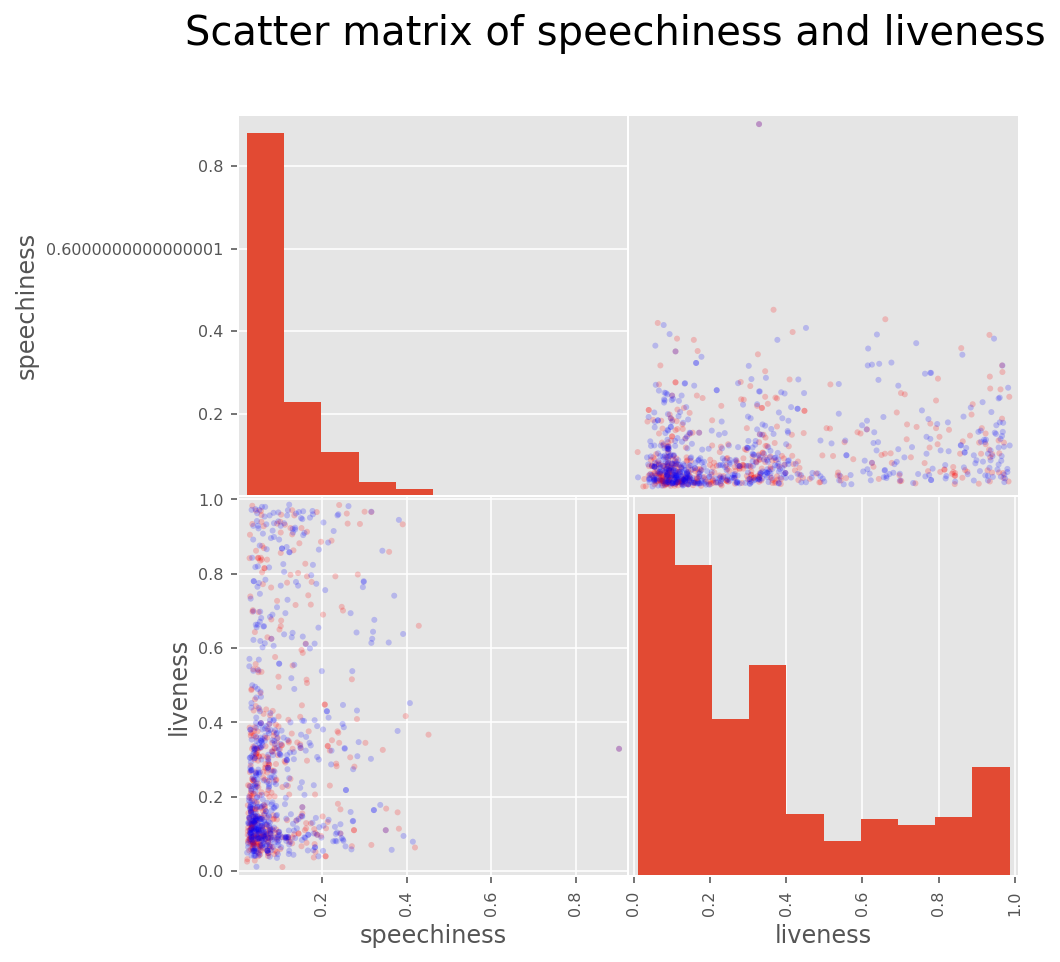

In [50]:
colors = ['red' if ix else 'blue' for ix in kpop_df.target]

scatter_matrix(kpop_df[['speechiness', 'liveness']].sample(1000), alpha = 0.2, figsize = (7,7), diagonal = 'hist', color = colors);
suptitle('Scatter matrix of speechiness and liveness', size = 20);

>The scatter matrix shows that the lower the speechiness, the lower the liveness. The red dots reflect individual BTS songs and the blue dots represent songs from other k-pop groups. Unlike previous analysis through tables, we can't really find the discernment between two target labels through visualization.

#### Focusing specifically on BTS vis-a-vis other k-pop groups

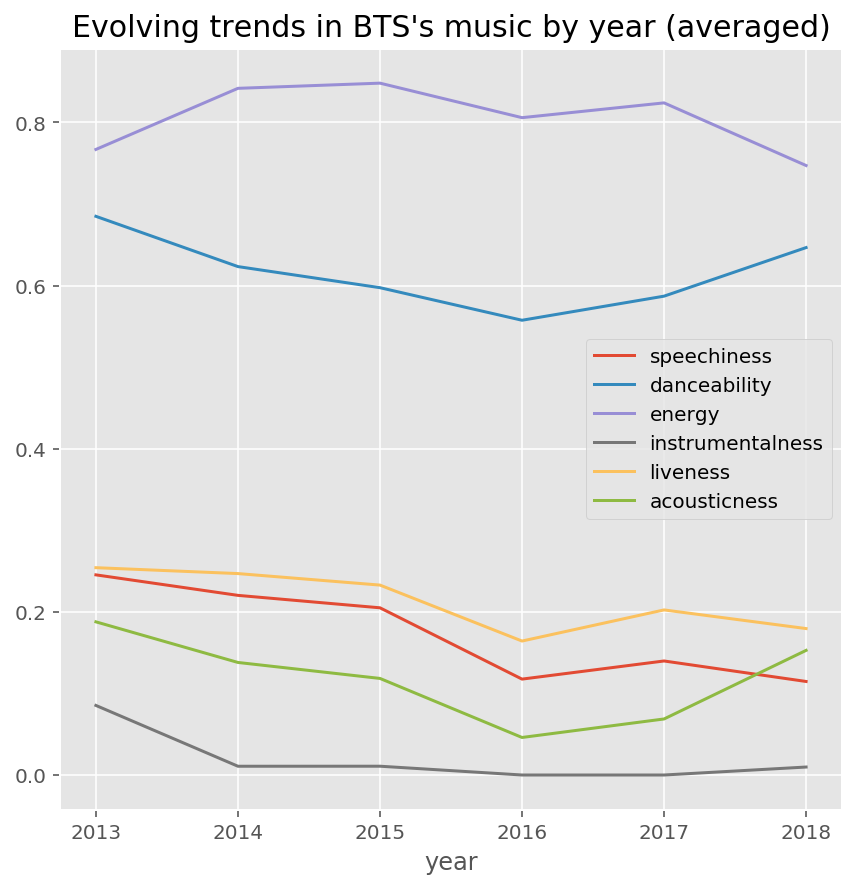

In [51]:
bts_grouped = kpop_df[kpop_df.artist_name == 'bts']
bts_grouped = bts_grouped[bts_grouped.year > 2012] # somehow seven 2011 tracks from another artists got mixed in as BTS. Getting rid of these
bts_grouped.groupby('year').agg({'speechiness':'mean', 'danceability':'mean', 'energy':'mean', 'instrumentalness':'mean', 'liveness':'mean', 'acousticness':'mean'}).plot(figsize = (7,7));
title('Evolving trends in BTS\'s music by year (averaged)', size = 15);

>Over the years, BTS music has become less and less instrumental to the point where their music no longer has instrumental sounds. This makes sense, since we've seen that BTS' songs have a lot of vocal presence (speechiness), which is inverse to instrumentalness, where "the greater likelihood the track contains no vocal content". Let us see the distribution of all of their features.

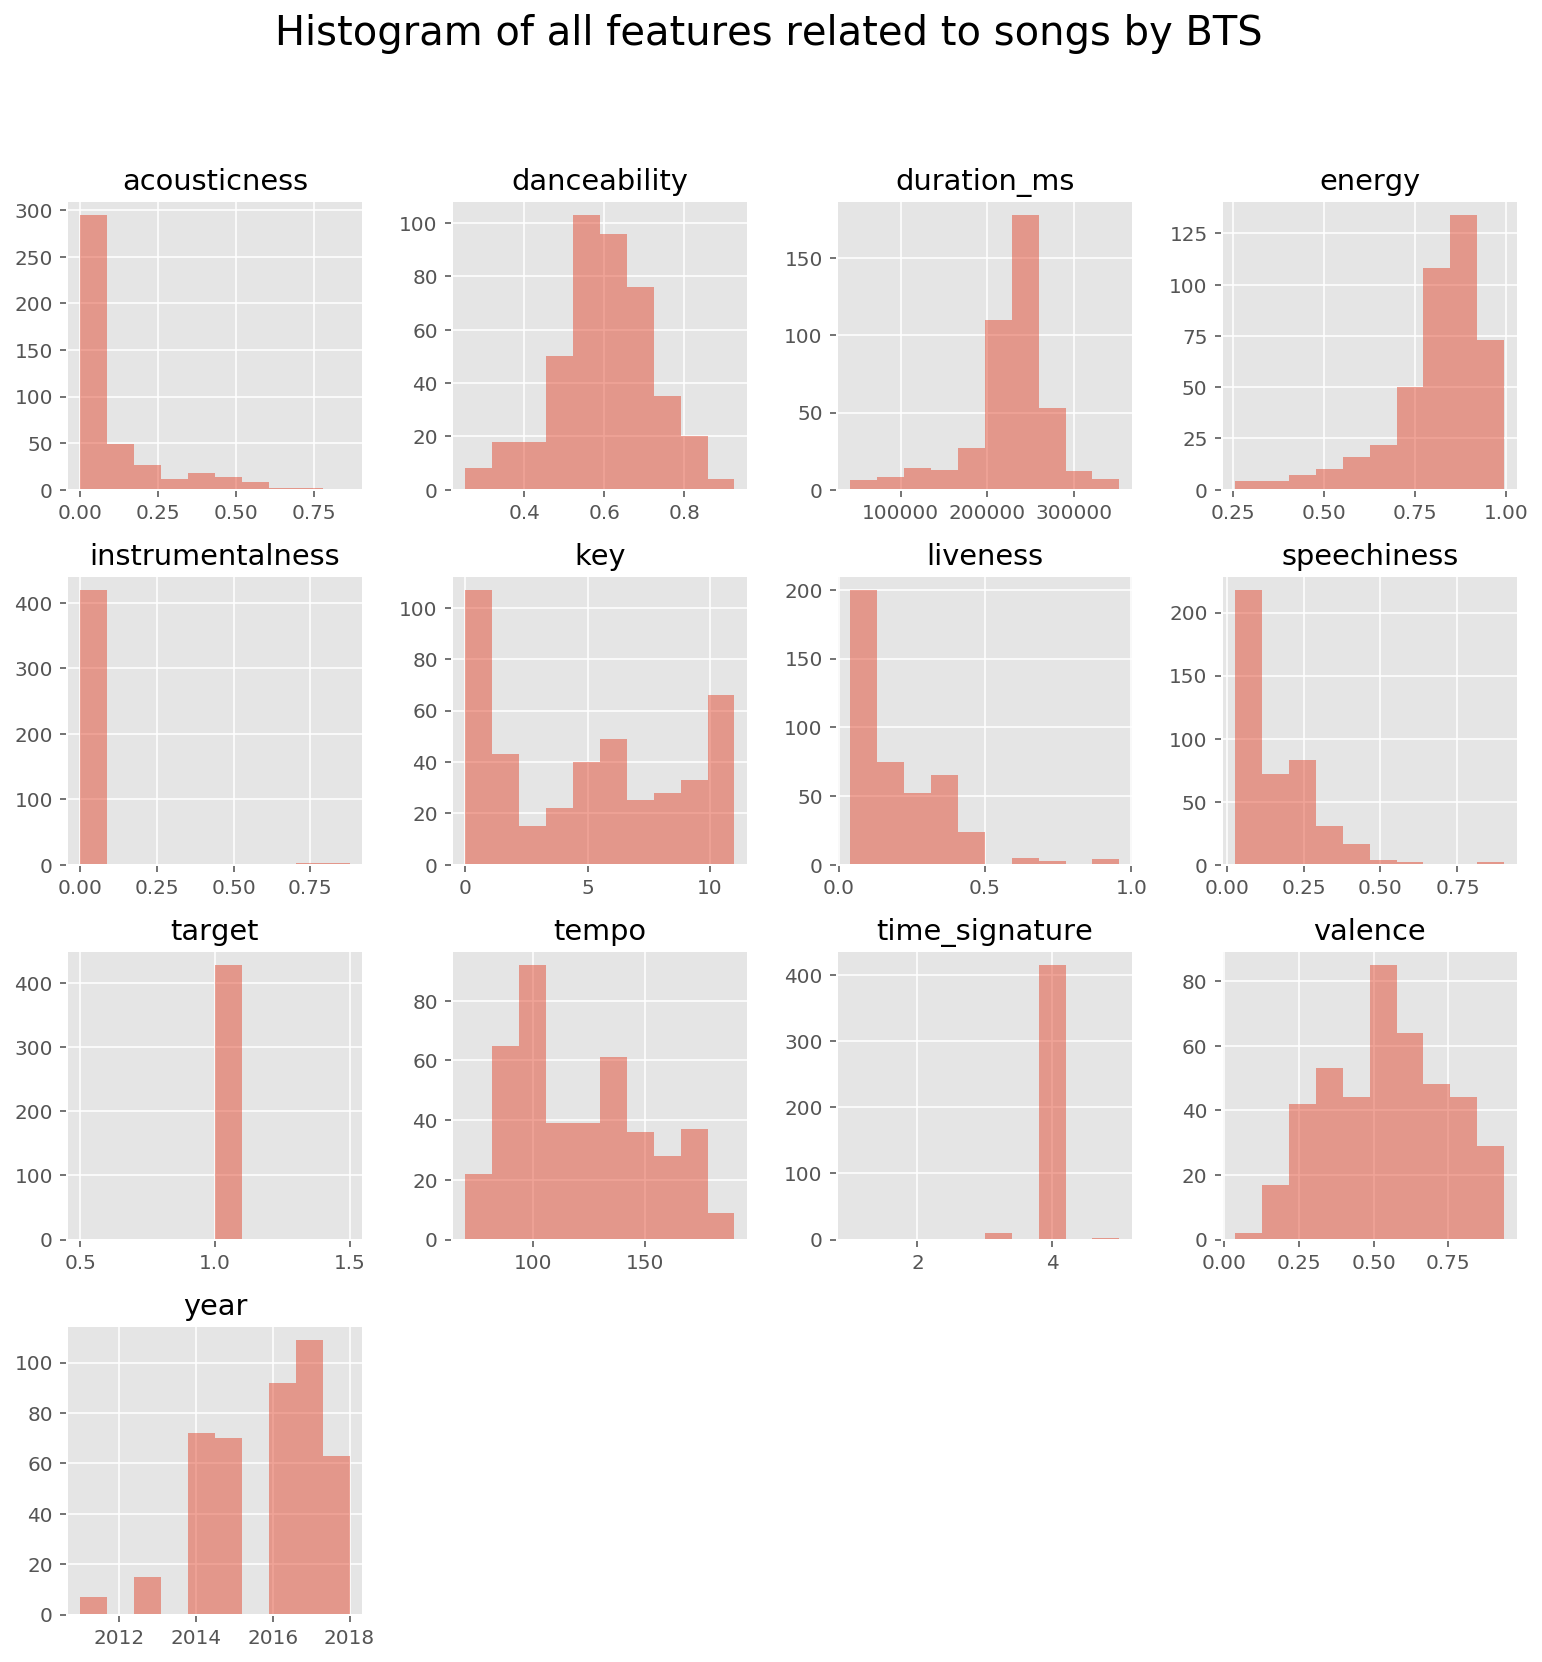

In [52]:
figure = figsize(13,13)
kpop_df[kpop_df.artist_name == 'bts']._get_numeric_data().hist(alpha = 0.5);
suptitle('Histogram of all features related to songs by BTS', size = 20);

These simple histrograms displays important musical qualities: 

1) BTS has been generally producing more music each year. 

2) Their songs are generally well-balanced in valenece (happiness/saddness of a song), tempo, and danceability. 

3) They are low in acousticness, high in energy. Speechiness is interesting here, where on average, the number is high, but in terms of the count, most songs are actually quite lower on the speechiness side. 

In [53]:
bts_tempo = kpop_df[kpop_df['artist_name'] == 'bts']['tempo']  
bigbang_tempo = kpop_df[kpop_df['artist_name'] == 'bigbang']['tempo']  
ikon_tempo = kpop_df[kpop_df['artist_name'] == 'ikon']['tempo']  

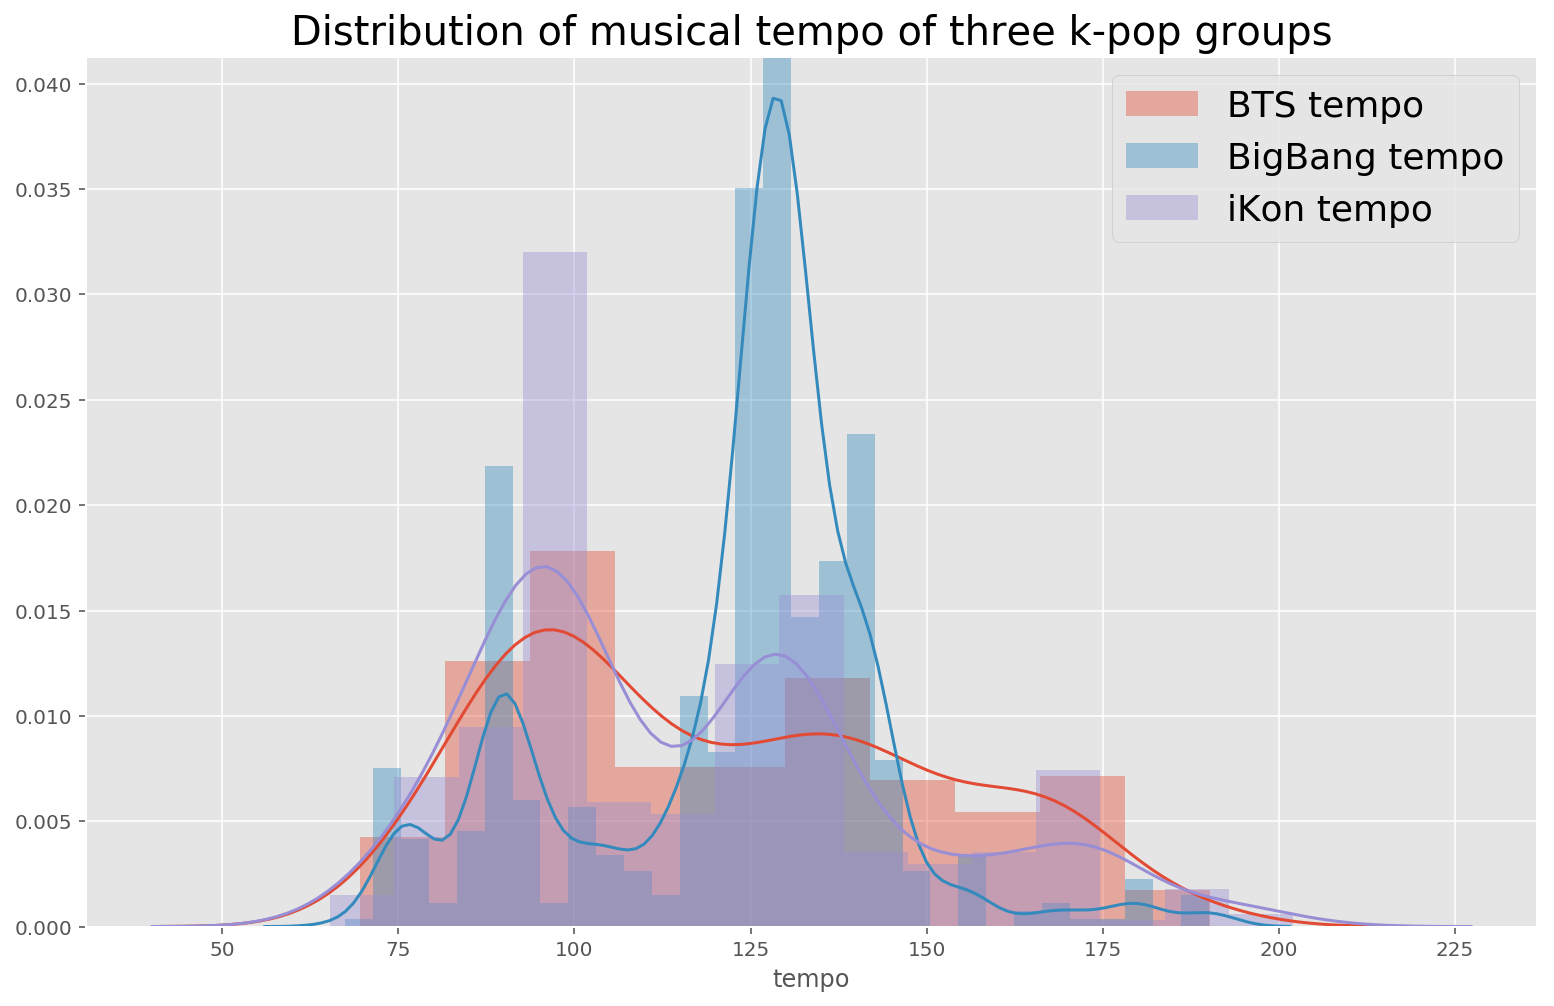

In [54]:
figure = figsize(13,8)
sns.distplot(bts_tempo, label = 'BTS tempo');
sns.distplot(bigbang_tempo, label = 'BigBang tempo');
sns.distplot(ikon_tempo, label = 'iKon tempo');
title('Distribution of musical tempo of three k-pop groups', size = 20)
legend(prop = {'size': 18});

>Visualization makes difference between groups all the more transparent. We see that while Big Bang's songs are mostly centered in a tempo of 125 and ikon's songs are centered around 90, BTS's songs are far more diverse and distributed. 

# $$2.\ Modeling$$

## 2.1 Baseline Modeling for a BTS Classifier

A simple baseline model is a good practice to determine a baseline score to improve upon.

I will choose three popular (tree-based) boosting algorithms.

- LIghtGBM Classifier 
- Gradientboost Classifier
- RandomForest Classifier

I will also use a oversampling technique (**SMOTE**) to address the class imbalance issue.

In [55]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations


In [56]:
kpop_df.head()

,danceability,energy,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,release_date,song_name,song_name_formatted,year,target
0,0.637,0.799,2,0.0338,0.3940,0.0,0.0921,0.562,104.995,228615,4,bts,2018-08-24,Euphoria,euphoria,2018,1
1,0.723,0.906,1,0.2790,0.0907,0.0,0.0771,0.398,125.019,225221,4,bts,2018-08-24,Trivia 起 : Just Dance,trivia-just-dance,2018,1
2,0.347,0.578,8,0.0626,0.4450,0.0,0.2310,0.226,86.730,276708,5,bts,2018-08-24,Serendipity (Full Length Edition),serendipity-length,2018,1
3,0.599,0.774,1,0.0541,0.0223,0.0,0.0669,0.696,129.819,223123,4,bts,2018-08-24,DNA,dna,2018,1
4,0.612,0.844,5,0.0756,0.1420,0.0,0.2870,0.653,134.868,196776,4,bts,2018-08-24,Dimple,dimple,2018,1


In [57]:
kpop_df_copy = kpop_df.copy()
kpop_df = kpop_df.drop(['artist_name','release_date','year','song_name','song_name_formatted'], 1)

In [58]:
X_train, X_validation, y_train, y_validation = train_test_split(kpop_df.iloc[:,:-1], kpop_df.target, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

In [59]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('index')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('index')

In [60]:
lgb_c = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
lgb_c.fit(X_train_smote, y_train_smote,
           eval_set=[(X_validation_smote, y_validation_smote)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=200,)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.386319	valid_0's auc: 0.920989
[400]	valid_0's binary_logloss: 0.327191	valid_0's auc: 0.940223
[600]	valid_0's binary_logloss: 0.31222	valid_0's auc: 0.946408
[800]	valid_0's binary_logloss: 0.30949	valid_0's auc: 0.950242
Early stopping, best iteration is:
[717]	valid_0's binary_logloss: 0.307784	valid_0's auc: 0.94939


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=50, reg_alpha=0.1, reg_lambda=0.1,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [61]:
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
gbc.fit(X_train_smote, y_train_smote)

validation_pred_proba_grad = gbc.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.929441476949923

In [62]:
rf = RandomForestClassifier()
rf.fit(X_train_smote,y_train_smote)

validation_pred_proba_grad = rf.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.9236891029543057

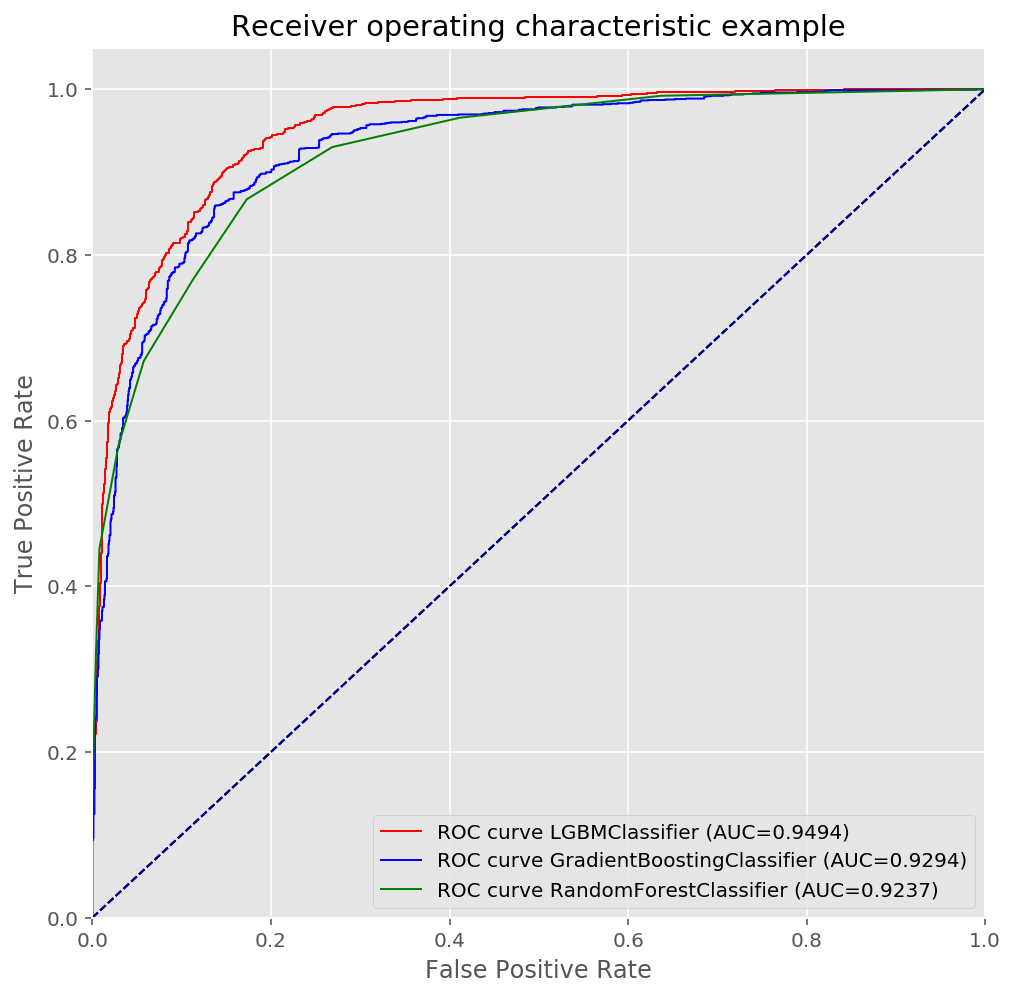

In [63]:
def plot_roc(model, X_validation, y_validation,  color):
    validation_pred_proba = model.predict_proba(X_validation)
    fpr, tpr, thresholds = roc_curve(y_validation, validation_pred_proba[:,1])
    auc = roc_auc_score(y_validation, validation_pred_proba[:,1])

    plt.plot(fpr, tpr, color=color,lw=1, label='ROC curve {} (AUC={:0.4f})'.format(model.__class__.__name__,auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right");
    
figure = figsize(8,8)
plot_roc(lgb_c, X_validation_smote, y_validation_smote, 'r')
plot_roc(gbc, X_validation_smote, y_validation_smote, 'b')
plot_roc(rf, X_validation_smote, y_validation_smote, 'g')

>Each model is performing phenomenally in terms of AUC score. LGBM performs the best, even though this and every other model has not been optimized. I suspect this has to do with the deterministic aspect of the data, meaning it's not prone to randomness and stochatisticity usually seen in data related to user/consumer behaviors.

## 2.2 Feature Importance

Feature Importance is a traditional algorithm that tells us which features are most important across the entire data. It is therefore called a __global interpretation__ that measures "global" trends, rather than local ones -- the latter of which will be discussed later.

- LGBMClassifier

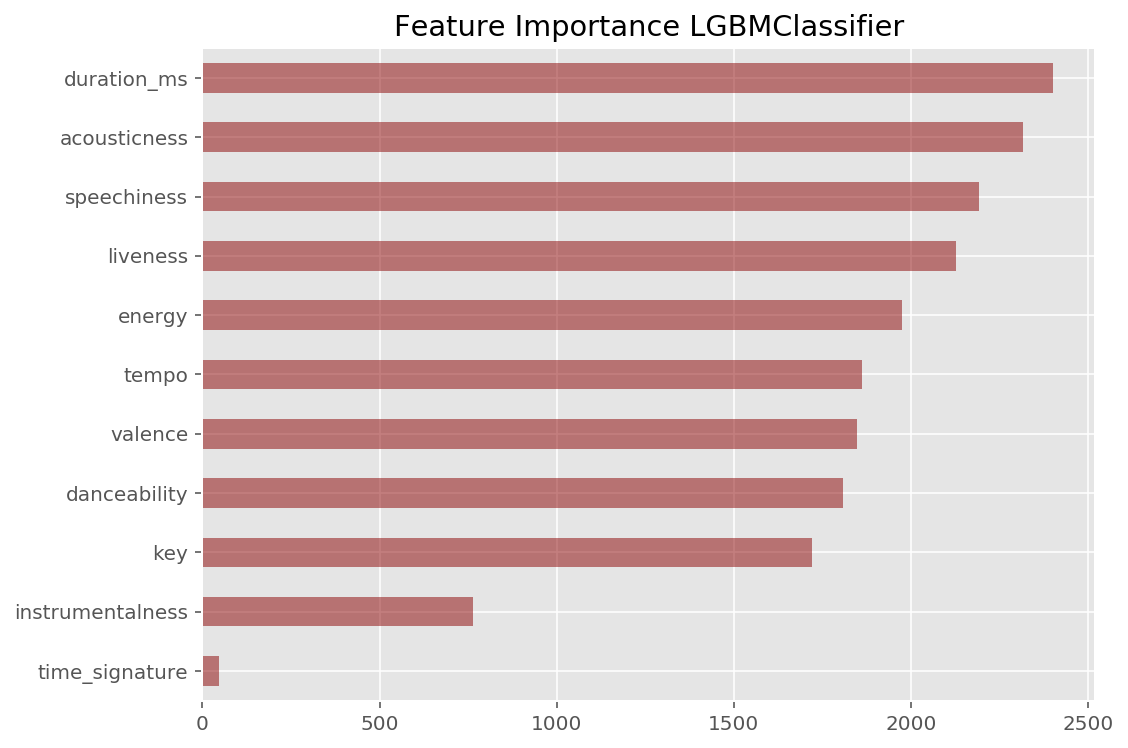

In [64]:
importance_series = pd.Series(data=lgb_c.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(8,6), color='darkred', alpha=0.5)
ax.set_title('Feature Importance LGBMClassifier');

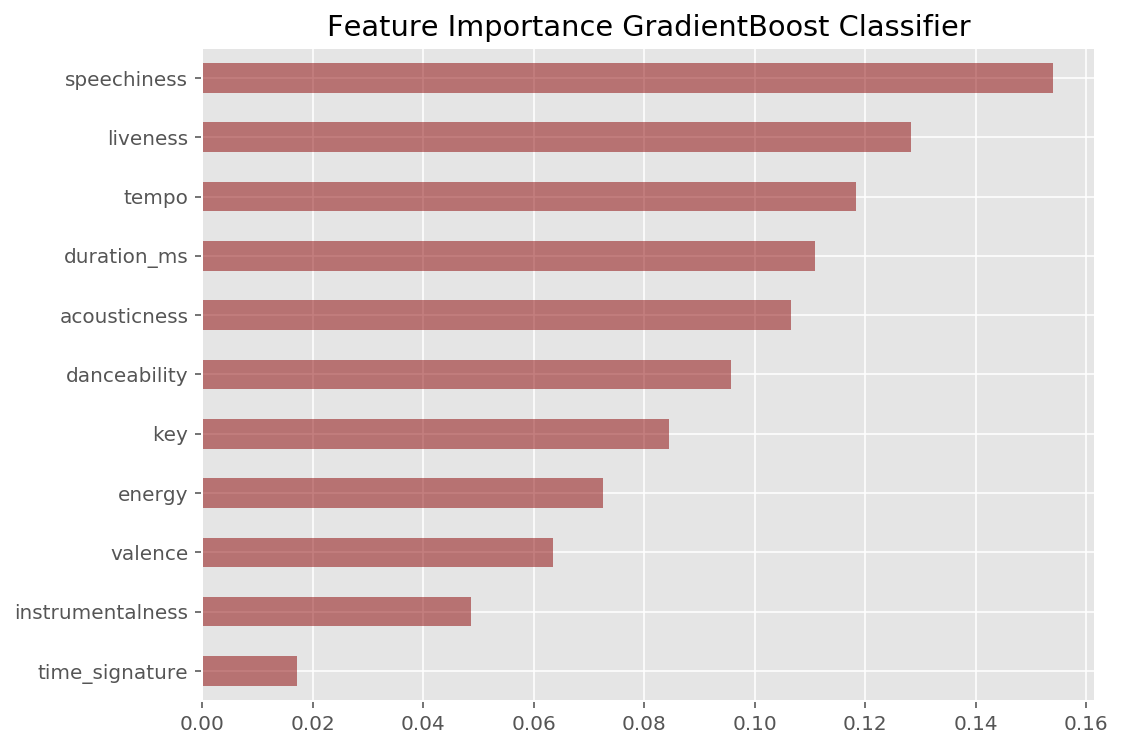

In [65]:
importance_series = pd.Series(data=gbc.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(8,6), color='darkred', alpha=0.5)
ax.set_title('Feature Importance GradientBoost Classifier');

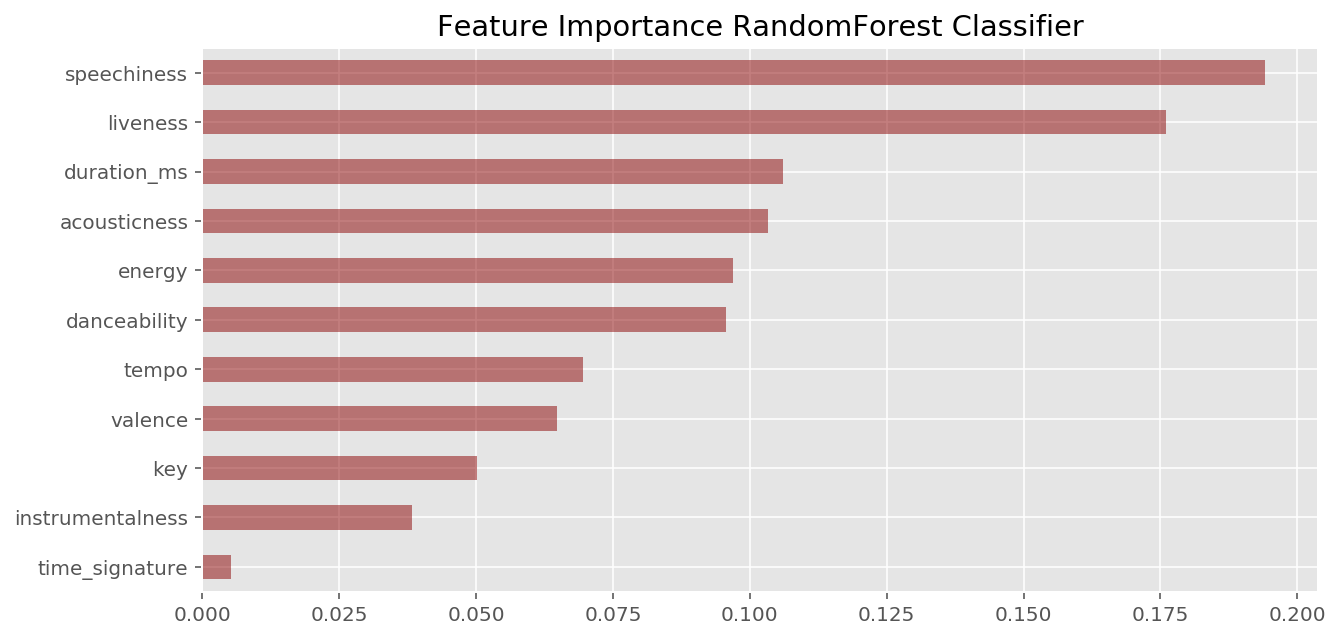

In [66]:
importance_series = pd.Series(data=rf.feature_importances_, index=X_validation_smote.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(10,5), color='darkred', alpha=0.5)
ax.set_title('Feature Importance RandomForest Classifier');

Feature Importance is a good initial way of measuring feature importance. But there are many problems with this measurement, which I won't go into here. Due to several issues of feature importance, many other metrics have been invented, which I term Feature Impact.

- The Feature Impact of _LightGBMClassifier_ on model output. I base Feature Impact partly on the SHAP values, based on the Shapley value that calculates how much each feature individually contributes to the final prediction, negatively or positively. One huge advantage of SHAP values is their local interpretability, meaning that each individual in our data is also assigned with his/her own SHAP value, allowing analysis on a 'local' level. The charts below will clarify what this means.

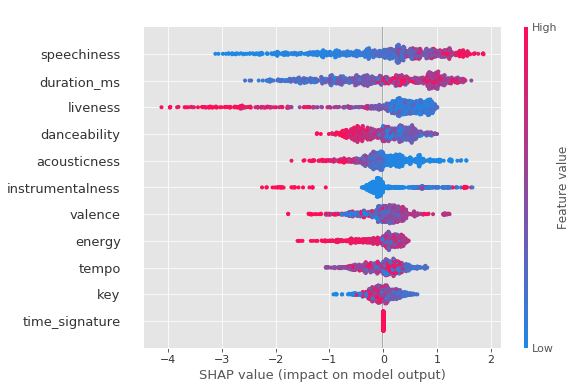

In [28]:
explainer = shap.TreeExplainer(lgb_c)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

>__How to read the chart__: The SHAP value is a mathematic calculation of how much each feature individually contributes to our machines  predicting if a certain song is by BTS or not.

>The left y-axis shows that the higher the features are on the list, the more impact they have on the model predicting whether a certain song is by BTS. In other words, speechiness had the most impact on the model prediction. Also, the chart plots every SHAP value for every datapoint in our 11 musical features. Thus, each dot (representing each song) in the chart is unique.
The magnitude of positive and negative influence on model output is shown by how spread out the dots are from the center. Positivity and negativity are measured through a specific formula that I won't go into here. Colors blue and red in the chart represent their feature value. For instance, the red dots represent the higher levels of speechiness and the blue represents the lower values speechiness.

>If you combine this entire information, the plot above shows that speechiness is the most important feature for model prediction. The higher the number of speechiness, the more that song influenced our machines in predicting it to be from BTS. This conversely means that the model predicts lower levels  of speechiness to be associated with non-BTS groups. 
Liveness , our second most important feature, is a little more intricate, in that lower levels of liveness has a strong influence over non-BTS predictions, but the opposite is not the case, where higher recordings of liveness don't strongly influence BTS predictions.

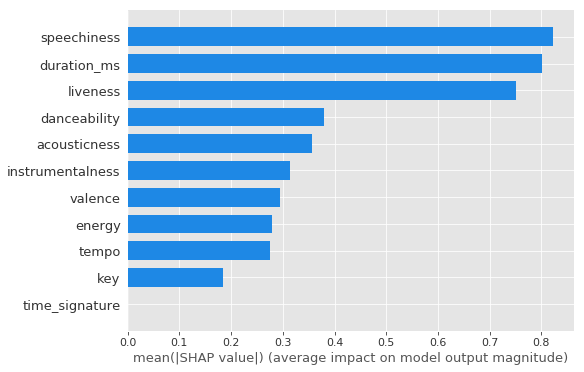

In [29]:
shap.summary_plot(shap_values, X_train_smote, plot_type = "bar")

In [30]:
import eli5
from eli5.sklearn import PermutationImportance

Permutation Importance is another good way of measuring feature importance, though the technique is much older than the SHAP Value. Its idea is very similar to SHAP Values in trying to measure how much the prediction score (accuracy, roc_auc, etc.) decreases when a feature is not available. The measurement is done by shuffling the features and measuring the model performance. Given their similar aims, it is no surprising that the output ranking is the same. However, the Permutation Importance doesn't tell us the direction of impact like SHAP Values. Nonetheless, it's a good tool to have.

In [31]:
perm = PermutationImportance(lgb_c).fit(X_train_smote, y_train_smote)
eli5.show_weights(perm, feature_names= X_train_smote.columns.tolist())

Weight,Feature
0.1348 ± 0.0074,speechiness
0.1158 ± 0.0164,liveness
0.1100 ± 0.0134,duration_ms
0.0362 ± 0.0119,valence
0.0339 ± 0.0047,danceability
0.0281 ± 0.0056,energy
0.0274 ± 0.0031,instrumentalness
0.0262 ± 0.0054,acousticness
0.0230 ± 0.0040,tempo
0.0158 ± 0.0048,key


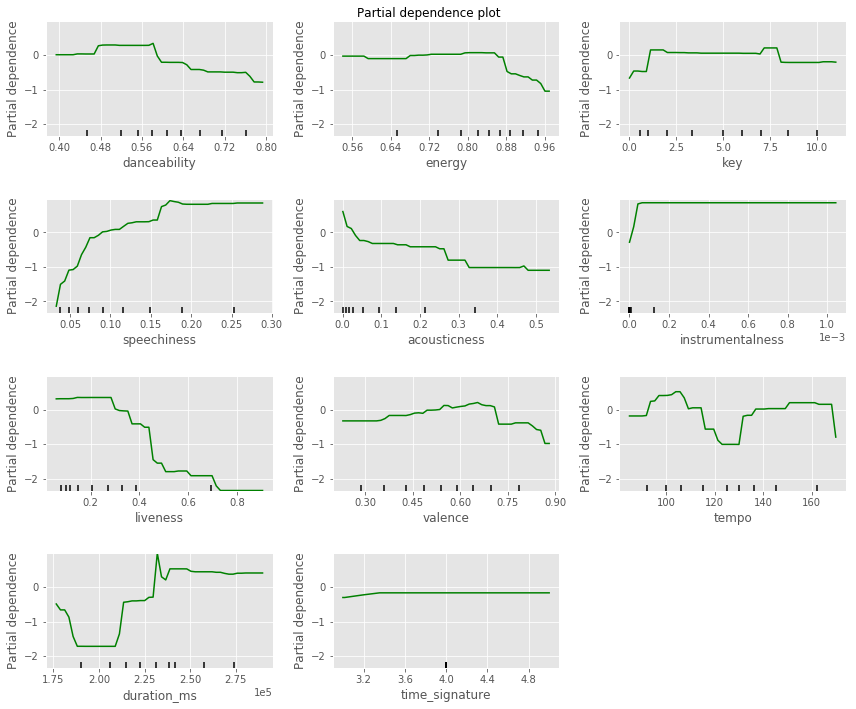

In [32]:
fig, axs = plot_partial_dependence(gbc, X_train_smote.values, features = range(len(X_train_smote.columns)),
                        feature_names=X_train_smote.columns, n_jobs=3, grid_resolution=50)

fig.set_size_inches(12, 10)
suptitle('Partial dependence plot', size=12);
tight_layout()

### Comparing Korean musical artists with American artists

I thought I'd take a quick time here to see how American pop musicians are different from Korean ones, especially compared to BTS.

In [102]:
apop_df = pd.read_csv('data/musical_data/merged_apop_song_features.csv', index_col = 0)

In [103]:
apop_df.artist_name.value_counts()

*NSYNC                1350
Bruno Mars            831 
Lady Gaga             705 
Taylor Swift          696 
Rihanna               631 
Backstreet Boys       606 
Katy Perry            556 
Kelly Clarkson        464 
One Direction         306 
Christina Aguilera    271 
Name: artist_name, dtype: int64

In [104]:
bts = kpop_df_copy[kpop_df_copy.artist_name == 'bts']

merged_df = pd.concat([apop_df, bts], join = 'inner')

In [105]:
merged_df.head()

,danceability,energy,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,release_date
0,0.523,0.883,8,0.0365,0.0202,0.0,0.1160,0.350,92.215,240000,4,One Direction,2015-11-13
1,0.730,0.703,0,0.0369,0.1090,0.0,0.0657,0.595,138.113,192120,4,One Direction,2015-11-13
2,0.647,0.823,2,0.0762,0.0598,0.0,0.1190,0.396,99.933,230333,4,One Direction,2015-11-13
3,0.537,0.705,4,0.0337,0.0687,0.0,0.0842,0.320,131.965,249480,4,One Direction,2015-11-13
4,0.502,0.594,11,0.0365,0.0256,0.0,0.0834,0.349,153.687,194973,5,One Direction,2015-11-13


In [106]:
merged_df['target'] = [1 if i == 'bts' else 0 for i in merged_df.artist_name]

merged_df.groupby('artist_name').agg({'speechiness':'mean', 'instrumentalness':'mean', 'danceability':'mean', 'energy':'mean','acousticness':'mean'}).sort_values('speechiness', ascending = False)

,speechiness,instrumentalness,danceability,energy,acousticness
artist_name,,,,,
bts,0.158097,0.012689,0.601540,0.812572,0.100711
Christina Aguilera,0.108485,0.063259,0.612107,0.668288,0.238418
Lady Gaga,0.084522,0.015907,0.632386,0.705692,0.167523
Kelly Clarkson,0.082163,0.007363,0.551369,0.702889,0.166611
Rihanna,0.080839,0.011942,0.617027,0.675086,0.156436
Bruno Mars,0.073292,0.026226,0.647408,0.644171,0.238233
Katy Perry,0.061527,0.001338,0.632005,0.751266,0.088522
*NSYNC,0.058087,0.020642,0.606690,0.676935,0.224102
Backstreet Boys,0.054636,0.011073,0.609911,0.721334,0.138418


In [107]:
merged_df = merged_df.drop(['release_date','artist_name'],1)

In [110]:
X_train, X_validation, y_train, y_validation = train_test_split(merged_df.iloc[:,:-1], merged_df.target, train_size=0.2)

X_train_lgbm = pd.get_dummies(X_train)
X_validation_lgbm = pd.get_dummies(X_validation)

X_train_lgbm.reset_index(inplace = True)
X_validation_lgbm.reset_index(inplace = True)

In [111]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_lgbm, y_train.ravel())
X_validation_smote, y_validation_smote = sm.fit_sample(X_validation_lgbm, y_validation.ravel())

X_train_smote = pd.DataFrame(X_train_smote, columns = X_train_lgbm.columns).set_index('index')
X_validation_smote = pd.DataFrame(X_validation_smote, columns = X_validation_lgbm.columns).set_index('index')

In [112]:
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
gbc.fit(X_train_smote, y_train_smote)

validation_pred_proba_grad = gbc.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.9345446916678973

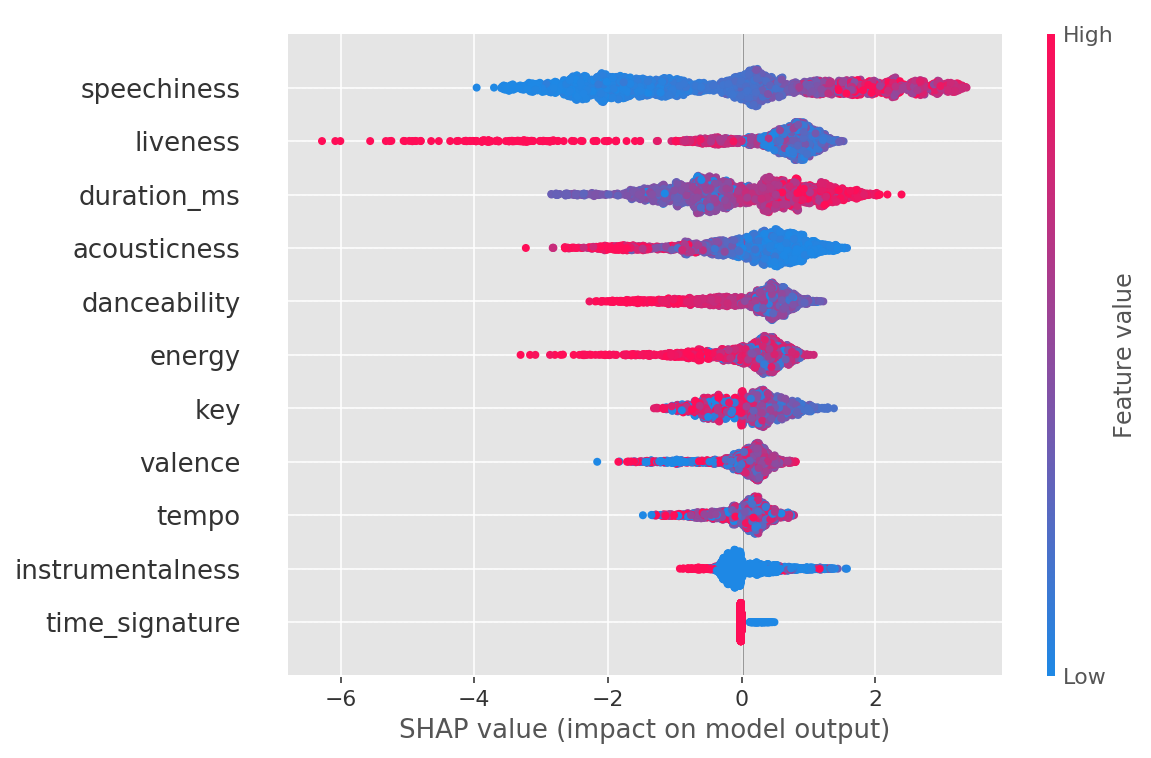

In [113]:
explainer = shap.TreeExplainer(lgb_c)
shap_values = explainer.shap_values(X_train_smote)

shap.summary_plot(shap_values, X_train_smote)

# $$3.\ Lyrics\ and\ Natural\ Language \ Processing$$

__Load and Clean Textual Data__

In [2]:
# Data I have already cleaned the data using strip_meta_text and other functions. I will also pursue a one-v-all approach here.

all_lyrics = pd.read_csv('data/lyrics_data/Korean_lyrics/merged_original_kpop_lyrics.csv', index_col = 0)
translated_lyrics = pd.read_csv('data/lyrics_data/translated_lyrics/all_lyrics.csv', index_col = 0)

In [272]:
all_lyrics.shape

(293, 3)

## 3.1. Tfidf and LIME

__LIME__, or Local Interpretable Model-Agnostic Explanations, is a great tool for measuring which words in a particular document influence our classifiers and toward what direction (BTS or non-BTS). We first have to vectorize our words into a matrix, fit the matrix into our model, and deploy the LIME from there. 

It should be mentioned LIME only works with word embedding that doesn't change dimension of the original vector space, such as count vectorizer, tfidf, etc. Doc2Vec will not work on LIME since the model transforms the original matrix of our vectorized words during training. 

This is a standard problem of model complexity vs. model interpretability. Doc2Vec word representations will generally grant higher performance for our classifiers (if the document has lots of words). But you will unfortunately lose model interpretability. If you want lower model performance but higher interpretabiity, LIME and Tfidf is a great choice (again, based on the size of our documents). 

__The work below will flesh out this trade-off.__

In [3]:
#Tokenize words
words = list(doc_to_words(translated_lyrics.text))


# Removing stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
 
def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text]


words = remove_stopwords(words)


# lemmatize words
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts_out = []
    for idx, sent in enumerate(texts):
        if (idx) % 500 == 0:
            print(str(idx) + ' documents lemmatised')
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


0 documents lemmatised


In [4]:
lemmatized_data = pd.Series(data_lemmatized).apply(lambda x: ' '.join(x))

In [5]:
# Train test split

X_train, X_validation, y_train, y_validation = train_test_split(lemmatized_data, translated_lyrics.target, test_size= 0.2, random_state=13)


In [7]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_sample(X_train_vectorized, y_train)
X_validation_smote, y_validation_smote = sm.fit_sample(validation_features, y_validation)


In [8]:
rf = RandomForestClassifier()
rf.fit(X_train_smote,y_train_smote)

validation_pred_proba_grad = rf.predict_proba(X_validation_smote)
roc_auc_score(y_validation_smote, validation_pred_proba_grad[:,1])

0.8277777777777778

>After filtering the translated lyrics, Random Forest is able to achieve an AUC of 0.77

### LIME (Local Interpretable Model-Agnostic Explanations)

In [111]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

class_names = ['BTS', 'non-BTS']

explainer = LimeTextExplainer(class_names=class_names)

c = make_pipeline(vectorizer, rf)



In [112]:
target_indices = all_lyrics[all_lyrics.target == 1].index

In [113]:
bts_lyrics = X_validation[target_indices].dropna().index

In [114]:
X_validation.loc[bts_lyrics[0]]

'could pretend happy sad could pretend strong hurt wish love perfect love wish weakness could hidden grow flower bloom dream come true be sick fake love fake love fake love be sorry fake love fake love fake love wanna good man give world change everything dunno forest route take forget even become quite unsure try babble mirror could pretend happy sad could pretend strong hurt wish love perfect love wish weakness could hiddeni grow flower bloom dream come true love bad love bad mold pretty lie love mad love mad try erase make doll love bad love bad mold pretty lie love mad love mad try erase make doll be sick fake love fake love fake love be sorry fake love fake love fake love sad know know smile say love look even give even understand say unfamiliar change use say know well mean blind love love fake love woo woo even even know woo know know know fake love fake love fake love love bad love bad mold pretty lie love mad love mad try erase make doll love bad love bad mold pretty lie love 

In [124]:
idx = bts_lyrics[0]

exp = explainer.explain_instance(X_validation.loc[idx], c.predict_proba, num_features=6)
# print('Document id: %d' % )
print('Document id: {}'.format(idx))
print('Probability(of being BTS) =', c.predict_proba([X_validation.loc[idx]])[:,1])
print('True class: %s' % class_names[y_validation.loc[idx]])


Document id: 7
Probability(of being BTS) = [0.2]
True class: BTS


In [74]:
exp.show_in_notebook(text=True)

>A demonstration of LIME at work. For document0 (1st lyric in our test set), our clssifier predicted the document of being BTS with a probability of 20%, with the true label being a BTS. I think visualization will be very helpful. 

>Below, I filtered the search even more. I looked at only BTS lyrics in our test set, and visualized which words influenced our model to sway our classifier to predict the individual lyric as being from BTS or not.

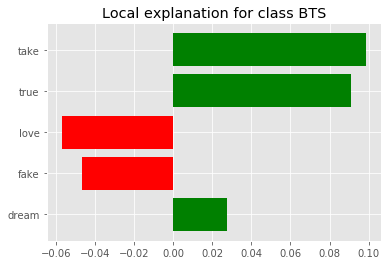

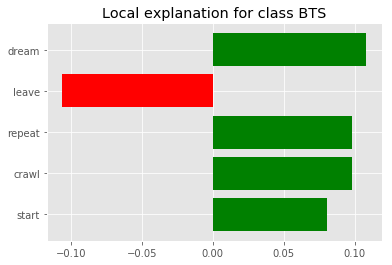

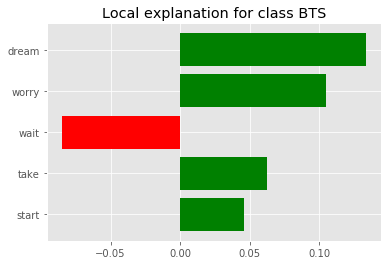

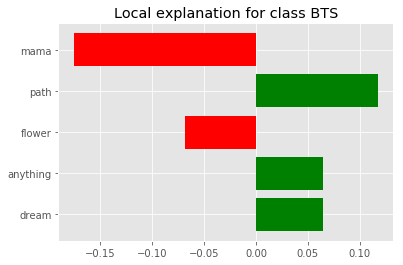

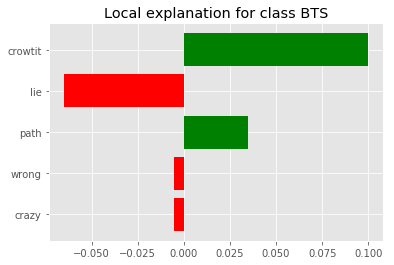

In [60]:
for i in bts_lyrics[:5]:
    exp = explainer.explain_instance(X_validation.loc[i], c.predict_proba, num_features=5)
    fig = exp.as_pyplot_figure()
    

In [122]:
i = 0
explainer_dic = {}

while i < len(bts_lyrics):
    exp = explainer.explain_instance(X_validation.loc[bts_lyrics[i]], c.predict_proba, num_features=5)
    for element in exp.as_list():
        if element[1] > 0:
            explainer_dic[element[0]] = float(element[1])
    i+=1        

>Through the code above, I extracted all the words in our BTS lyrics that LIME has explained as influencing our model toward BTS prediction.

In [125]:
explainer_dic

{'take': 0.10340225174665484,
 'true': 0.08839608984391398,
 'dream': 0.11481120538788107,
 'repeat': 0.04829827152840472,
 'crawl': 0.09350919889200171,
 'start': 0.10082710885819908,
 'worry': 0.040037002321341185,
 'path': 0.03555436942022494,
 'anything': 0.11366817288743888,
 'crowtit': 0.09948153862795081,
 'bury': 0.11551697028530321,
 'much': 0.10744799294152094,
 'music': 0.10785116343586426,
 'run': 0.06899438242273954,
 'push': 0.09732051762154581,
 'bathroom': 0.09717998650973675,
 'scream': 0.0625024763393254,
 'way': 0.05588628239038032,
 'year': 0.036250024872707884,
 'alone': 0.08085145166001181,
 'mom': 0.09275298313518525,
 'perfume': 0.07170371444072214,
 'fine': 0.11509915555503467,
 'damn': 0.1058032464603969,
 'must': 0.051638158665554414}

In [132]:
k = []
for i in explainer_dic:
    k.append((i, float(explainer_dic[i])))

In [137]:
sorted_explainer_dic = sorted(k, key=lambda x: x[1], reverse= True)

In [139]:
for i in sorted_explainer_dic:
    print(i)

('bury', 0.11551697028530321)
('fine', 0.11509915555503467)
('dream', 0.11481120538788107)
('anything', 0.11366817288743888)
('music', 0.10785116343586426)
('much', 0.10744799294152094)
('damn', 0.1058032464603969)
('take', 0.10340225174665484)
('start', 0.10082710885819908)
('crowtit', 0.09948153862795081)
('push', 0.09732051762154581)
('bathroom', 0.09717998650973675)
('crawl', 0.09350919889200171)
('mom', 0.09275298313518525)
('true', 0.08839608984391398)
('alone', 0.08085145166001181)
('perfume', 0.07170371444072214)
('run', 0.06899438242273954)
('scream', 0.0625024763393254)
('way', 0.05588628239038032)
('must', 0.051638158665554414)
('repeat', 0.04829827152840472)
('worry', 0.040037002321341185)
('year', 0.036250024872707884)
('path', 0.03555436942022494)


## 3.2 Doc2Vec with Gensim

Gensim's Doc2Vec is an easy way to boost model performance, especially if each document is filled with lots of words. Again, we have to sacrifice model interpretability. But we can do some cool visualization still, as well as unsupervised learning techniques. We will explore that below.

__NOTE__: There are modules out there that combines local interpretation with document vectorizing. LDA2Vec is an instance, but that module is completely broken as of Oct 26, 2018.

In [3]:
# gensim modules
import gensim
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec, Word2Vec

# numpy
import numpy

# classifier
from sklearn.linear_model import LogisticRegression

# random
import random

from NLP_helper_functions import *

In [6]:
# Tweaking the LabeledLineSentence class to allow separation of labels and a list of words for multiple files

class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [7]:
sources = {'data/lyrics_data/Korean_lyrics/lyrics.txt':'kpop_lyrics'}

sentences = LabeledLineSentence(sources)

In [10]:
doc_model = Doc2Vec(min_count=1, window=10, size=150, sample=1e-4, negative=5, workers=7)

doc_model.build_vocab(sentences.to_array())
 
# doc_model.train(sentences.sentences_perm(), total_examples=doc_model.corpus_count, epochs= 1000)

# doc_model.save('data/korean_doc2vecmodel')


gensim_model = gensim.models.Doc2Vec.load('data/doc2vec_models/korean_doc2vecmodel')

print(gensim_model.docvecs.most_similar(1))

[('kpop_lyrics_225', 0.5506149530410767), ('kpop_lyrics_284', 0.5396972894668579), ('kpop_lyrics_196', 0.5393305420875549), ('kpop_lyrics_278', 0.5298721194267273), ('kpop_lyrics_224', 0.5291990041732788), ('kpop_lyrics_147', 0.5281609296798706), ('kpop_lyrics_285', 0.5262923836708069), ('kpop_lyrics_80', 0.526212215423584), ('kpop_lyrics_248', 0.5231412649154663), ('kpop_lyrics_29', 0.5207343101501465)]


>Training our Gensim Model. After training, we can see which documents are similar to each other.

In [261]:
all_lyrics.loc[[1, 277, 73]]

,name,text,target,group
1,trivia-just-dance,"내게 그 순간을 묻는다면 환하게 내리쬔 sunshine 그 느낌을 묻는다면 자연스레 내 눈에 one shot 그 분위기 속 음악을 틀고 각자의 스트레칭 긴장은 풀려 지금 내 마음을 숨긴다면 후회했어 너와의 sunset hey, dance with me dance with me 어떤 바운스도 좋아 dance with me 어디서 왔고, 왜 춤을 추고 자연스러운 대화 say something 이상해, 너무 잘 맞기에 뭐든지 잘 될 거 같아 but you’re my friend, yeah my friend just.. 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance 음악의 리듬대로 그저 몸이 가는대로 우린 달빛 아래 shadow fall in.. fall in.. 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance uh 진흙 같은 내 삶 속 uh 한 송이 너란 꽃 uh 꽉 막힌 연습실도 uh 함께라면 낙원으로 ay 답도 없던 꿈도 이제 ay 공감대 형성이 매일 돼 ay 우리의 리듬은 맞기에 춤이 있었기에, 그 운명적인 박 let’s get it on pop 웨이브로 물결치는 감 심장의 뜀박 하나 되는 동작 너로 알아가는 지금 내 마음 계속 이어 나가고 싶은 걸 춤을 좋아했듯이, 널 so you’re my love, yeah my love that’s what i like 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance 음악의 리듬대로 그저 몸이 가는대로 우린 달빛 아래 shadow fall in.. fall in.. 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance 느꼈어 baby 순간 너와 나 baby 그 모든 합이 공식같이 맞춰진 걸 baby 막연함도 baby 큰 힘듦도 baby 너 하나로 다 위로가 된다는 걸 baby 느꼈어 baby 순간 너와 나 baby 그 모든 합이 공식같이 맞춰진 걸 baby 거친 숨도 baby 흘린 땀도baby 너 하나로 다 의미가 된다는 걸 baby 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance",1,BTS
277,wolf,"촉이 와 단번에 느껴 널 한입에 치즈처럼 집어넣을 테다 향길 맡고 색깔 음미하고 와인보다 우아하게 잡아먹을 테다 아 그런데 발톱에 힘이 빠져 입맛까지 으 없어져 혹시 내가 아픈 건가 병이라도 걸린 거니? yeah! 큰일났지 헤이 정신차려, 어쩌다 인간에게 맘을 뺏겨버렸나 그녀는 한입거리뿐이라고 hey 확 물어 그 다음 막 막 흔들어 정신 잃게 hey 자 안 해본 스타일로 저 큰 보름달이 지기 전에 해치워라 그래 wolf, 내가 wolf! awouuuu 아 사랑해요 난 늑대고 넌 미녀 그래 wolf, 내가 wolf! awouuuu 아 사랑해요 난 늑대고 넌 미녀 거부할 수 없이 강렬한 이 느낌에 빠져버려 나를 놨어 난 단순한 게 좋아 내 속에 숨어있던 것이 지금 눈 떴어 yeah! 그녈 좀 봐 공포에 빠져 눈앞의 시추에이션 이해 못해 못해 저 더러운 늑대 놈이 결국 날 잡아먹겠지 그게 아닌데, 사랑에 빠진 겁니다 너무 아름다 아름다 아름다운! 그대 내 님아 내 님아 내 님아 whoo! 나를 두려워 두려워 두려워마! 나는 특별한 특별한 특별한 wolf! 그대 사랑한 사랑한 사랑한 wolf! 네게 눈이 먼 눈이 먼 눈이 먼 wolf! hey 확 물어 그 다음 막 막 흔들어 정신 잃게 hey 자 안 해본 스타일로 저 큰 보름달이 지기 전에 해치워라 그래 wolf, 내가 wolf! awouuuu 아 사랑해요 난 늑대고 넌 미녀 그래 wolf, 내가 wolf! awouuuu 아 사랑해요 난 늑대고 넌 미녀 널 못 끊겠어 큰일났어 널 못 끊겠어 큰일났어 저 노란 달이 나를 놀려 널 가질 수 없다고 난 그냥 거친 야수인데 그딴 말 할거면 꺼져, 필요하다면 날 바꿔 그녈 절대 보낼 수가 없어 거부할 수 없이 강렬한 이 느낌에 빠져버려 나를 놨어 난 단순한 게 좋아 내 속에 숨어있던 것이 지금 눈 떴어 거부할 수 없이 강렬한 이 느낌에 빠져버려 나를 놨어 난 단순한 게 좋아 내 속에 숨어있던 것이 지금 눈 떴어 그래 wolf, 내가 wolf! awouuuu 아 사랑해요 난 늑대고 넌 미녀 그래 wolf, 내가 wolf! awouuuu 아 사랑해요 난 늑대고 넌 미녀",0,Other
73,beautiful,쌀쌀한 바람 코끝이 찡해져도 기분 좋아 따뜻한 우유 나의 매일 아침을 깨워주네 버스정류장 사람들 다른 곳을 보거나 다른 노래 듣는 중 내가 널 생각하는지 네가 알까 모를까 모르겠네 모두들 어디를 그리 바쁘게 가는지 옆자리 아저씨 누구랑 통화하는지 모두 너무 바빠 너무 바빠 너무 바빠해 나도 너를 생각하느라 너무 너무 바쁘네 my life is so beautiful my life is so beautiful 어쩌면 매일 똑같은 일상 같지만서도 특별해 너와 함께면 beautiful 너만 생각하면 whenever paradise paradise beautiful 네 손잡을 때면 wherever paradise paradise beautiful 긴긴 하루가 지날 때 너의 옆에 있어줄게 내가 네게 내가 oh 내가 네게 내가 이른 아침 해와 함께 떠오른 너 내리쬐는 빛 따스한 너의 온기를 연상시켜 밤공기에 스쳐 잠들어 꿈속까지 들어온 넌 변함없이 다음 날 나를 깨워줘 거릴 거니는 사람들 앞만 보고 걷거나 자기 볼일 보는 중 내가 널 생각하는지 네가 알까 모를까 모르겠네 모두들 어디를 그리 바쁘게 가는지 저기 저 커플은 뭐가 그렇게 좋은지 모두 너무 바빠 너무 바빠 너무 바빠해 나도 너를 생각하느라 너무너무 바쁘네 my life is so beautiful my life is so beautiful 어쩌면 매일 똑같은 일상 같지만서도 특별해 너와 함께면 beautiful 너만 생각하면 whenever paradise paradise beautiful 네 손잡을 때면 wherever paradise paradise beautiful 긴긴 하루가 지날 때 너의 옆에 있어줄게 내가 네게 내가 oh 내가 네게 내가 paradise 눈앞에 있는 것들 촉각 시각 청각 미각 세상에 시드는 꽃은 많지만 여기 있는 것들은 시들지가 않아 우린 사랑을 절대 쉬지 않아 beautiful 너만 생각하면 whenever paradise paradise beautiful 네 손잡을 때면 wherever paradise paradise beautiful 긴긴 하루가 지날 때 너의 옆에 있어줄게 내가 네게 내가 oh 내가 네게 내가,0,Other


In [210]:
sources = {'data/lyrics_data/translated_lyrics/lyrics.txt':'kpop_lyrics'}

sentences = LabeledLineSentence(sources)

translated_doc_model = Doc2Vec(min_count=1, window=10, size=150, sample=1e-4, negative=5, workers=7)

translated_doc_model.build_vocab(sentences.to_array())


 
# translated_model = gensim.models.Doc2Vec.load('data/translated_doc2vecmodel')

# print(translated_model.docvecs.most_similar(1))

[('kpop_lyrics_198', 0.5578610897064209), ('kpop_lyrics_202', 0.5482962131500244), ('kpop_lyrics_195', 0.5481056571006775), ('kpop_lyrics_192', 0.5473950505256653), ('kpop_lyrics_183', 0.5457456707954407), ('kpop_lyrics_185', 0.5415102243423462), ('kpop_lyrics_50', 0.5390806198120117), ('kpop_lyrics_201', 0.5381156206130981), ('kpop_lyrics_190', 0.5362104177474976), ('kpop_lyrics_194', 0.5316249132156372)]


In [176]:
translated_lyrics.loc[[1, 198, 202]]

,name,text,target
indices,,,
1,trivia-just-dance,if you ask me about that moment bright sunshine was falling down if you ask me about that feeling naturally it was a one shot into my eyes music playing in those vibes we each stretch getting rid of the nerves if i hid my heart i would’ve regretted it watching this sunset with you hey dance with me dance with me any kind of bounce is fine dance with me where are you from why are you dancing a natural conversation say something it’s weird we’re connecting too much feels like everything will go well but you’re my friend yeah my friend just i like the feeling of being with you i like the feeling of dancing with you i just wanna wanna wanna i really wanna wanna wanna just dance to the rhythm of the music however our bodies move we’re shadows underneath the moonlight fall in fall in i like the feeling of being with you i like the feeling of dancing with you i just wanna wanna wanna i really wanna wanna wanna just dance in my muddy life you were like a single stem flower even this suffocating studio if we’re together turns into paradise my dreams that once had no answer now becomes something we can relate to because our rhythm is matching because we have our dance it’s a fatelike beat let’s get it on pop washing me over with those waves our heartbeats are in sync you’re getting to know my heart too i wanna keep this going i like you like i like to dance so you’re my love yeah my love that’s what i like i like the feeling of being with you i like the feeling of dancing with you i just wanna wanna wanna i really wanna wanna wanna just dance to the rhythm of the music however our bodies move we’re shadows underneath the moonlight fall in fall in i like the feeling of being with you i like the feeling of dancing with you i just wanna wanna wanna i really wanna wanna wanna just dance i felt it baby this moment you and me baby this all fits together like a math formula baby even obscurities baby even difficulties baby because of you i’m comforted from all of that baby i felt it baby this moment you and me baby this all fits together like a math formula baby even rough breathing baby even shedding sweat baby because of you it all has meaning baby i like the feeling of being with you i like the feeling of dancing with you i just wanna wanna wanna i really wanna wanna wanna just dance,1
198,love-dust,my friend talked about you when he said you looked good i got pointlessly angry maybe i still wanted you to suffer because of me these days without knowing i sing the songs we used to listen to together on days like this when i’m locked in old memories on nights when i miss you for no reason i was too young back then love was hard so i tried to avoid you it was too much pressure for me and so i was unhappy so eventually i made you cry when today passes you will disappear like dust – what is love if i look sad my tears are like smoke like dancing smoke tomorrow my day will start like nothing is wrong and i will forget you i’ll just remain here smiling as i pray that you will be happy do you remember the day we first met innocent smiles filled with sauvignon blanc my submission to you without reason sometimes our strong clashes when separation became our fatelike reality my last wrath i hear stories from the radio that i agree with it’s exactly how i feel right now i wonder if the story was sent by you as i fall asleep time passes so fast – i wonder if you’re doing well i was too young back then love was hard so i tried to escape eventually it was too much pressure so i became unhappy although now it’s too late when today passes you will disappear like dust – what is love if i look sad my tears are like smoke like dancing smoke tomorrow my day will start like nothing is wrong and i will forget you i’ll just remain here smiling as i pray that you will be happy if we ever run into each other on the streets i hope we will look happy as we smile each with a different person so long when today passes you

### Checking how unseen lyrics gets recognized by our trained model

I will use BTS' 'Airplane' lyrics that was not included in our doc2vec. We will see where 'Airplane' gets placed in the multi-dimensional vector space to find other lyrics similar to this one.

In [73]:
airplane = ['''이상한 꼬마 숨쉬듯 노래했네 어디든 좋아 음악이 하고 싶었네 오직 노래 심장을 뛰게 하던 thing 하나뿐이던 길을 걸었지만 쉽지 않아 실패와 절망 지친 날 누군가 불러 세워 건넨 말 You’re a singing star You’re a singing star But I see no star 몇년이 흘러가버린 뒤 Sky high, sky fly, sky dope (We still) Same try, same scar, same work
(We still) 세상 어딜 가도 (We still) 호텔방서 작업 (I still) 하루는 너무 잘 돼 그 다음날은 망해 (I still) 오늘은 뭐로 살지 김남준 아님 RM? 스물다섯, 잘 사는 법은 아직도 보르겠어 그러니 오늘도 우리는 그냥 go We goin’ from NY to Cali London to Paris 우리가 가는 그 곳이 어디든 party El Mariachi
El Mariachi El Mariachi We goin’ from Tokyo, Italy Hong Kong to Brazil 이 세계 어디서라도 난 노래하리 El Mariachi El Mariachi El Mariachi El Mariachi (ooh, ooh, ooh, ooh) 구름 위를 매일 구름 위를 매일 eh oh 구름 위에 내 feel 구름 위에 check it eh oh 구름과의 케미 구름과 하루 종일 eh eh 구름 타는 재미, 구름 보며 fade in 너흰 몰라 maybe 몇 년 동안의 비행 탓에 마일리지만 몇 심만 대 못 이룬 너희들을 위로해줄 때야 그 비행 포인트로 선물 할게 Love 에어플레인 모드 신경은 다 off 그 누구든지 뭐라던 그저 계속 퍼스트를 지키며
밤 하늘을 볼게 지금 내 자리에 맞춰 I don’t know, I don’t know, I don’t know, I don’t know 그래 멈추는 법도 I don’t know, I don’t know, I don’t know, I don’t know 그래 좀 쉬는 법도 I don’t know, I don’t know, I don’t know, I don’t know 실패하는 법도
I don’t know, I don’t know, I don’t know, I don’t know TV 나와서 하는 귀여운 돈 자랑들은 fed up 여권은 과로사 직전 미디어의 혜택은 되려 너네가 받았지 깔깔깔 깔 야 야 셀럽놀이는 너네가 더 잘해 우린 여전히 그때와 똑같어 woo! We goin’ from Mexico City London to Paris
우리가 가는 그 곳이 어디든 party El Mariachi El Mariachi El Mariachi We goin’ from Tokyo, Italy Hong Kong to Brazil 이 세계 어디서라도 난 노래하리 El Mariachi El Mariachi El Mariachi (El Mariachi) El Mariachi (ooh, hoo, hoo, hoo)''']


In [74]:
ivec = gensim_model.infer_vector(doc_words=airplane, steps=20, alpha=0.025)
print(gensim_model.docvecs.most_similar(positive=[ivec], topn=10))

[('kpop_lyrics_110', 0.1570480465888977), ('kpop_lyrics_250', 0.13360068202018738), ('kpop_lyrics_190', 0.12818442285060883), ('kpop_lyrics_18', 0.12420828640460968), ('kpop_lyrics_70', 0.09164361655712128), ('kpop_lyrics_188', 0.09092076122760773), ('kpop_lyrics_152', 0.08661988377571106), ('kpop_lyrics_257', 0.08614128828048706), ('kpop_lyrics_211', 0.08535885065793991), ('kpop_lyrics_106', 0.08003997057676315)]


In [126]:
# Code below is for creating a mini-dataframe with only document vectors nearest to airplane

num = []
for i in gensim_model.docvecs.most_similar(positive=[ivec], topn=10):
    lyrics = i[0]
    num.append(int(lyrics[12:]))

percentage = []
for i in gensim_model.docvecs.most_similar(positive=[ivec], topn=10):
    percentage.append(round(i[1], 4))
    
k = pd.DataFrame(percentage)
k.index = num
    
nearest = all_lyrics.loc[num].join(k)
nearest = nearest.rename(columns = {'name':'song_name_formatted', 0:'similarity_score'})
merged_nearest = pd.merge(kpop_df, nearest, on = 'song_name_formatted', how = 'right')[['song_name_formatted','artist_name','text','similarity_score']].drop_duplicates()

merged_nearest = merged_nearest.fillna('EXO').drop(5) # had some strange error where I had a duplicate I needed to delete and a nan value I needed to fillin 
merged_nearest.sort_values(by = 'similarity_score', ascending = False)

,song_name_formatted,artist_name,text,similarity_score
15,wanna-be-my-baby,Wanna One,oh oh oh wanna be my baby wanna be my baby 이런 ...,0.1570
17,lotto,EXO,별 관심이 없는 척 시선을 피해서 가 yeah 이해해 모든 걸 걸어야만 할 테니까...,0.1336
8,perfect-10,Red Velvet,light camera action uh 모든 게 다 완벽해 hit the butt...,0.1282
0,mic-drop,BTS,"yeah, 누가 내 수저 더럽대 i don't care, 마이크 잡음 금수...",0.1242
3,miss-right,BTS,"you're my miss right, miss right 널 놓친다면 mis...",0.0916
11,time-to-love,Red Velvet,간절하게 꿈을 꿔 매일 포근한 눈 속을 함께 걷기 아득하게 멀었던 일 그랬던 내 옆...,0.0909
10,complete,Girls' Generation,눈부신 계절 가득히 향기로운 거릴 지나 조심스런 내 발걸음 두근거려 저기 멀리 ...,0.0866
16,one-and-only,iKON,허락된 공기로 쉬는 숨 헤엄쳐봐도 결국 여긴 너의 품 꿈에서도 너란 꿈을 꾸는 ...,0.0861
12,zoo,Red Velvet,ooh ho ooh ho 눈을 떴는데 온통 이상해 대체 무슨 일이야 하늘을 날다 툭...,0.0854
13,wanna,Wanna One,너의 이름까지 갖고 싶어 너의 눈빛 작은 손짓 하나까지 너의 기억까지 안고 싶어 너...,0.0800


#### Preparing data for Tensorboard T-SNE

In [286]:
# doc_model.save_word2vec_format('doc_tensor.w2v', doctag_vec=True, word_vec=False)

In [ ]:
# myfile = open('Kpop_lyrics_meta_data.tsv','w')
# for i in pd.Series(all_lyrics.name + " " + all_lyrics.group):
#     myfile.write("%s\n" % i)
    
# myfile.close()

In [288]:
# %run word2vec2tensor.py -i doc_tensor.w2v -o kpoplyrics

## 3.3 Creating a BTS Classifier

BTS classifier with Gensim

In [35]:
train_arrays = np.zeros((all_lyrics.shape[0], gensim_model['kpop_lyrics_0'].shape[0]))
train_labels = np.array(all_lyrics.target)

for i in range(all_lyrics.text.shape[0]):
    train_arrays[i] = gensim_model['kpop_lyrics_' + str(i)]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_arrays, train_labels, test_size = .2, random_state = 40)    

In [ ]:
classifier = LogisticRegression()

classifier.fit(x_train, y_train)

In [ ]:
y_pred = classifier.predict(x_test)

accuracy_score(y_test,y_pred)

In [ ]:
lgb_model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1)
lgb_model.fit(x_train, y_train,
           eval_set=[(x_test, y_test)],
           early_stopping_rounds=10000,
eval_metric='auc',
verbose=200,)

In [ ]:
shap_explainer = shap.TreeExplainer(lgb_model)
shap_values = shap_explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train)

>Doesn't mean anything, since doc2vec's features aren't interpretable. 

## 3.4 Unsupervised Learning with Latent Dirichlet Allocation 

Latent Dirichlet Allocation (LDA) is an unsupervised NLP technique for topical modeling, or extracting themes/topics in a document. LDA will be used to answer the question: __are BTS lyrics really that unique compared to other k-pop lyrics?__ This is a claim made by many BTS fans, which LDA can help us address.

In [5]:
from konlpy.tag import Kkma
from konlpy.utils import pprint
from nltk import pos_tag, word_tokenize
import enchant

d = enchant.Dict("en_US")
kkma = Kkma()

In [6]:
#removing single quote characters
text_corpus = all_lyrics.text.values.tolist()
text_corpus = [re.sub("\'", "", doc) for doc in text_corpus]

In [7]:
filtered_text = []
for i in text_corpus:
    text_corpus_filtered = []
    for j in kkma.pos(i):
        if not d.check(j[0]):
            if j[1] == 'NNG':
                text_corpus_filtered.append(j[0])
    filtered_text.append(text_corpus_filtered)
            

# Use the code below if you want to include English words

# filtered_text = []
# for i in text_corpus:
#     text_corpus_filtered = []
#     for j in kkma.pos(i):
#         if j[1] == 'NNG':
#             text_corpus_filtered.append(j[0])
#     words = word_tokenize(i)
#     for k in pos_tag(words):
#         if d.check(k[0]):
#             if len(k[0]) > 1 and k[1] == 'NN' or k[1] == 'NNS':
#                 text_corpus_filtered.append(k[0])
                
#     text.append(text_corpus_filtered)


>I have filtered the text to only include nouns for easier topic extraction. I am assuming here that verbs, adjectives, and adverbs don't add a whole lot to signal abstract topics compared to nouns. I have also decided to filter out English words within Korean lyrics, though often English words are a huge part of Korean lyrics. The reason for this is that English words usually speak the same message as Korean words, and feel like duplicates rather than unique originals that could generate signal for topic modeling.

In [11]:
#Tokenizing words

warnings.simplefilter("ignore", DeprecationWarning)

words = list(doc_to_words(filtered_text))

def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in filtered_text]


# Removing stopwords

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
 
words = remove_stopwords(words)


# lemmatizing words

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts_out = []
    for idx, sent in enumerate(texts):
        if (idx) % 500 == 0:
            print(str(idx) + ' documents lemmatised')
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

0 documents lemmatised


In [59]:
# Creating dictionary and the corpus for gensim's built-in LDA model

import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
 
# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]
 
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           per_word_topics=True)

In [60]:
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# # Show graph
# limit=40; start=2; step=6;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

>Coherence values are a way of measuring the relevant number of topics for the LDA model. Feel Free to try it out, though the difference in results haven't been spectacular, mostly due to the high similarity among all K-pop lyrics in thematic conent.

In [61]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.034532  0.025532  1       1        30.801407
4     -0.031244 -0.129630  2       1        24.049988
3     -0.021736 -0.000518  3       1        18.012709
2      0.150917  0.016113  4       1        15.659133
0     -0.063405  0.088503  5       1        11.476770, topic_info=     Category       Freq   Term      Total  loglift  logprob
term                                                        
209   Default  72.000000  기대     72.000000  30.0000  30.0000
10    Default  69.000000  느낌     69.000000  29.0000  29.0000
639   Default  29.000000  유행가    29.000000  28.0000  28.0000
25    Default  28.000000  사람     28.000000  27.0000  27.0000
160   Default  32.000000  눈물     32.000000  26.0000  26.0000
759   Default  17.000000  눈빛     17.000000  25.0000  25.0000
42    Default  26.000000  최고     26.000000  24.0000  24.0000
13    Default  82.000000  순간     82.000000  23.0000  23.0000
308   Default  18.000000  손짓     18.000000  22.0000  22.0000
38    Default  16.000000  원해     16.000000  21.0000  21.0000
928   Default  9.000000   데이트    9.000000   20.0000  20.0000
1010  Default  5.000000   화살     5.000000   19.0000  19.0000
56    Default  36.000000  모습     36.000000  18.0000  18.0000
96    Default  13.000000  태도     13.000000  17.0000  17.0000
90    Default  14.000000  미로     14.000000  16.0000  16.0000
838   Default  14.000000  칵테일    14.000000  15.0000  15.0000
430   Default  6.000000   시험     6.000000   14.0000  14.0000
584   Default  6.000000   브레이커   6.000000   13.0000  13.0000
44    Default  28.000000  목소리    28.000000  12.0000  12.0000
9     Default  43.000000  너와     43.000000  11.0000  11.0000
526   Default  6.000000   새벽     6.000000   10.0000  10.0000
895   Default  4.000000   첫사랑    4.000000   9.0000   9.0000 
84    Default  5.000000   더러러    5.000000   8.0000   8.0000 
78    Default  36.000000  이별     36.000000  7.0000   7.0000 
151   Default  13.000000  그때     13.000000  6.0000   6.0000 
480   Default  6.000000   대한민국   6.000000   5.0000   5.0000 
962   Default  5.000000   크리스마스  5.000000   4.0000   4.0000 
146   Default  5.000000   트로피    5.000000   3.0000   3.0000 
277   Default  6.000000   대구     6.000000   2.0000   2.0000 
239   Default  6.000000   믿음     6.000000   1.0000   1.0000 
96    Topic1   12.282334  태도     13.614050  1.0747  -4.6256 
455   Topic1   5.010244   호르몬    5.622221   1.0624  -5.5223 
845   Topic1   5.008580   줄다리기   5.622124   1.0621  -5.5226 
985   Topic1   5.004248   환상적    5.621918   1.0612  -5.5235 
765   Topic1   4.198453   페이지    4.813717   1.0409  -5.6991 
672   Topic1   4.196765   미래도    4.813761   1.0404  -5.6995 
669   Topic1   4.195759   과거     4.813739   1.0402  -5.6997 
42    Topic1   22.789881  최고     26.486876  1.0273  -4.0075 
722   Topic1   3.390930   일어     4.005460   1.0111  -5.9127 
245   Topic1   4.062129   봄날     4.798300   1.0111  -5.7321 
228   Topic1   3.972223   복잡     4.798635   0.9886  -5.7545 
31    Topic1   3.244464   거짓     4.003961   0.9673  -5.9568 
451   Topic1   2.585733   자제     3.197304   0.9653  -6.1838 
842   Topic1   2.583973   고무줄    3.197216   0.9647  -6.1845 
763   Topic1   2.583838   볼만     3.197195   0.9646  -6.1845 
761   Topic1   2.583832   멜로드라마  3.197194   0.9646  -6.1845 
544   Topic1   2.582746   무의미    3.197125   0.9642  -6.1849 
875   Topic1   2.581610   해피엔딩   3.197072   0.9638  -6.1854 
966   Topic1   2.581386   소리     3.197064   0.9637  -6.1855 
622   Topic1   2.580463   손님     3.197036   0.9634  -6.1858 
...      ...        ...   ..          ...      ...      ... 
957   Topic5   1.576259   제일     2.206677   1.8284  -5.6915 
117   Topic5   1.575375   쥐구멍    2.206760   1.8278  -5.6921 
1012  Topic5   1.575294   심술     2.206766   1.8278  -5.6921 
994   Topic5   1.574768   뒷얘기    2.206816   1.8274  -5.6924 
909   Topic5   1.574069   어제     2.206893   1.8269  -5.6929 
1048  Topic5   1.573430   너트     2.206941

>View the LDA visualization by going here: ...

In [62]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_corpus)

>Tie back the identified topics to the original documents

In [63]:
pd.set_option('display.max_colwidth', 0)
df_topic_sents_keywords[:3]

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,4,0.9094,"사랑, 세상, 눈물, 모습, 목소리, 손짓, 아침, 느낌, 순간, 바보",너는 내 삶에 다시 뜬 햇빛 어린 시절 내 꿈들의 재림 모르겠어 이 감정이 뭔지 혹시 여기도 꿈속인 건지 꿈은 사막의 푸른 신기루 내 안 깊은 곳의 a priori 숨이 막힐 듯이 행복해져 주변이 점점 더 투명해져 저기 멀리서 바다가 들려 꿈을 건너서 수풀 너머로 선명해지는 그 곳으로 가 take my hands now you are the cause of my euphoria euphoria take my hands now you are the cause of my euphoria euphoria close the door now when im with you im in utopia 너도 나처럼 지워진 꿈을 찾아 헤맸을까 운명 같은 흔한 말관 달라 아픈 너의 눈빛이 나와 같은 곳을 보는 걸 wont you please stay in dreams 저기 멀리서 바다가 들려 꿈을 건너서 수풀 너머로 선명해지는 그곳으로 가 take my hands now you are the cause of my euphoria euphoria take my hands now you are the cause of my euphoria 모래 바닥이 갈라진대도 그 누가 이 세겔 흔들어도 잡은 손 절대 놓지 말아 줘 제발 꿈에서 깨어나지 마 저기 멀리서 바다가 들려 꿈을 건너서 수풀 너머로 선명해지는 그곳으로 가 take my hands now you are the cause of my euphoria euphoria take my hands now you are the cause of my euphoria euphoria close the door now when i’m with you i’m in utopia
1,3,0.9550,"느낌, 유행가, 눈빛, 순간, 사랑, 원해, 소년단, 마지막, 시험, 브레이커","내게 그 순간을 묻는다면 환하게 내리쬔 sunshine 그 느낌을 묻는다면 자연스레 내 눈에 one shot 그 분위기 속 음악을 틀고 각자의 스트레칭 긴장은 풀려 지금 내 마음을 숨긴다면 후회했어 너와의 sunset hey, dance with me dance with me 어떤 바운스도 좋아 dance with me 어디서 왔고, 왜 춤을 추고 자연스러운 대화 say something 이상해, 너무 잘 맞기에 뭐든지 잘 될 거 같아 but you’re my friend, yeah my friend just.. 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance 음악의 리듬대로 그저 몸이 가는대로 우린 달빛 아래 shadow fall in.. fall in.. 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance uh 진흙 같은 내 삶 속 uh 한 송이 너란 꽃 uh 꽉 막힌 연습실도 uh 함께라면 낙원으로 ay 답도 없던 꿈도 이제 ay 공감대 형성이 매일 돼 ay 우리의 리듬은 맞기에 춤이 있었기에, 그 운명적인 박 let’s get it on pop 웨이브로 물결치는 감 심장의 뜀박 하나 되는 동작 너로 알아가는 지금 내 마음 계속 이어 나가고 싶은 걸 춤을 좋아했듯이, 널 so you’re my love, yeah my love that’s what i like 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance 음악의 리듬대로 그저 몸이 가는대로 우린 달빛 아래 shadow fall in.. fall in.. 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance 느꼈어 baby 순간 너와 나 baby 그 모든 합이 공식같이 맞춰진 걸 baby 막연함도 baby 큰 힘듦도 baby 너 하나로 다 위로가 된다는 걸 baby 느꼈어 baby 순간 너와 나 baby 그 모든 합이 공식같이 맞춰진 걸 baby 거친 숨도 baby 흘린 땀도baby 너 하나로 다 의미가 된다는 걸 baby 함께 하는 느낌이 좋아, 너와 함께 하는 춤들이 좋아, 너와 i just wanna, wanna, wanna i really wanna, wanna, wanna just dance"
2,2,0.8989,"순간, 사랑, 너와, 세상, 행복, 최고, 이별, 마지막, 생각, 태도",첫눈에 널 알아보게 됐어 서롤 불러왔던 것처럼 내 혈관 속 dna가 말해줘 내가 찾아 헤매던 너라는 걸 우리 만남은 수학의 공식 종교의 율법 우주의 섭리 내게 주어진 운명의 증거 너는 내 꿈의 출처 take it take it 너에게 내민 내 손은 정해진 숙명 걱정하지 마 love 이 모든 건 우연이 아니니까 우린 완전 달라 baby 운명을 찾아낸 둘이니까 우주가 생긴 그 날부터 계속 무한의 세기를 넘어서 계속 우린 전생에도 아마 다음 생에도 영원히 함께니까 이 모든 건 우연이 아니니까 운명을 찾아낸 둘이니까 dna i want it this love i want it real love 난 너에게만 집중해 좀 더 세게 날 이끄네 태초의 dna가 널 원하는데 이건 필연이야 i love us 우리만이 true lovers 그녀를 볼 때마다 소스라치게 놀라 신기하게 자꾸만 숨이 멎는 게 참 이상해 설마 이런 게 말로만 듣던 사랑이란 감정일까 애초부터 내 심장은 널 향해 뛰니까 걱정하지 마 love 이 모든 건 우연이 아니니까 우린 완전 달라 baby 운명을 찾아낸 둘이니까 우주가 생긴 그 날부터 계속 무한의 세기를 넘어서 계속 우린 전생에도 아마 다음 생에도 영원히 함께니까 이 모든 건 우연이 아니니까 운명을 찾아낸 둘이니까 dna 돌아보지 말아 운명을 찾아낸 우리니까 후회하지 말아 baby 영원히 영원히 영원히 영원히 함께니까 걱정하지 마 love 이 모든 건 우연이 아니니까 우린 완전 달라 baby 운명을 찾아낸 둘이니까 dna la la la la la la la la la la 우연이 아니니까 la la la la la la la la la la 우연이 아니니까 dna


In [64]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()


# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()
 
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
 
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
 
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)
 
# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
 

In [89]:
translation = pd.Series([['person','love','maze','arrow','world','eternity','thought','then','love','first love'],['moment','love','with you','world','happiness','best','farewell','last','thought','behavior'],['feeling','popular song','eye expression','moment','love','want it','boy scout','last','test','breaker'],['love','world','tear','appearance','voice','hand gesture','morning','feeling','moment','fool'],['expectation','world','thought','love','final','tears','farewell','happiness','date','boy scout']])

In [90]:
sent_topics_sorteddf.index.name = 'Topic'
sent_topics_sorteddf[['Keywords']]
sent_topics_sorteddf['Keywords Translation'] = translation

In [91]:
sent_topics_sorteddf[['Keywords','Keywords Translation']]

,Keywords,Keywords Translation
Topic,,
0,"사람, 사랑, 미로, 화살, 세상, 영원, 생각, 그때, 사랑이, 첫사랑","[person, love, maze, arrow, world, eternity, thought, then, love, first love]"
1,"순간, 사랑, 너와, 세상, 행복, 최고, 이별, 마지막, 생각, 태도","[moment, love, with you, world, happiness, best, farewell, last, thought, behavior]"
2,"느낌, 유행가, 눈빛, 순간, 사랑, 원해, 소년단, 마지막, 시험, 브레이커","[feeling, popular song, eye expression, moment, love, want it, boy scout, last, test, breaker]"
3,"사랑, 세상, 눈물, 모습, 목소리, 손짓, 아침, 느낌, 순간, 바보","[love, world, tear, appearance, voice, hand gesture, morning, feeling, moment, fool]"
4,"기대, 세상, 생각, 사랑, 마지막, 눈물, 이별, 행복, 데이트, 소년단","[expectation, world, thought, love, final, tears, farewell, happiness, date, boy scout]"


>The five topics are made up throught the Keywords that you see above. 

In [79]:
# Merge the dataframes together to get our target for each lyrics. The target will be used to see if BTS lyrics are actually unique.

df_topic_sents_keywords['name'] = all_lyrics.name
kpop_df = kpop_df.rename(columns = {'song_name_formatted':'name'})
merged_df = pd.merge(kpop_df, df_topic_sents_keywords, on = 'name')

merged_df['target'] = [1 if i == 'bts' else 0 for i in merged_df.artist_name]

In [80]:
merged_df = merged_df['Dominant_Topic Perc_Contribution Topic_Keywords name artist_name target'.split()]

In [81]:
merged_df = merged_df.drop_duplicates()

In [82]:
pd.crosstab(merged_df.target, merged_df.Dominant_Topic)

Dominant_Topic,1,2,3,4,5
target,,,,,
0,17,58,20,34,44
1,7,27,14,11,16


In [83]:
non_bts_crosstab_normalized = pd.crosstab(merged_df.target, merged_df.Dominant_Topic).loc[0] / sum(pd.crosstab(merged_df.target, merged_df.Dominant_Topic).loc[0].values) 
bts_crosstab_normalized = pd.crosstab(merged_df.target, merged_df.Dominant_Topic).loc[1] / sum(pd.crosstab(merged_df.target, merged_df.Dominant_Topic).loc[1].values) 

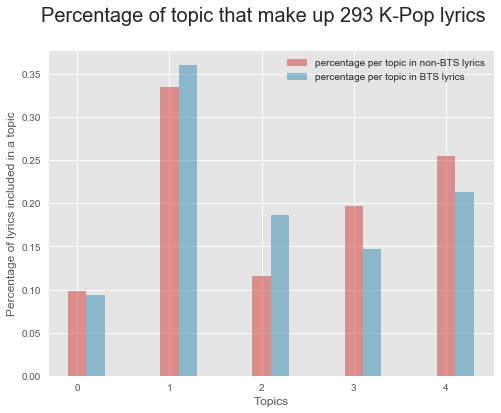

In [155]:
style.use('ggplot')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ind = np.arange(5)
width = 0.20


bar1 = ax.bar(ind, non_bts_crosstab_normalized.values, width, color = 'r', alpha = 0.4, label = 'percentage per topic in non-BTS lyrics')
bar2 = ax.bar(ind+width, bts_crosstab_normalized.values, width, color = 'b', alpha = 0.4, label = 'percentage per topic in BTS lyrics')

xlabel('Topics')
ylabel('Percentage of lyrics included in a topic')
legend();
suptitle('Percentage of topic that make up 293 K-Pop lyrics', size = 20);

>The barplot shows us here that there isn't much of huge difference between non-bts lyrics and bts lyrics in terms of thematic content. BTS and non-BTS songs share similar topic distribution for every unique topic. 